<a href="https://colab.research.google.com/github/yurim-nam/healthlytics/blob/main/EEG_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: EEG Depression Analysis

We extract power spectral density features from 128-channel EEG recordings across multiple frequency bands (delta, theta, alpha, beta, gamma) and apply Random Forest classification to identify which brain oscillations are most discriminative between MDD patients and healthy controls, with statistical significance testing via permutation analysis.

### Downloading & Organizing Dataset

In [ ]:
# downloading data
!wget -O eeg_data.zip "https://reshare.ukdataservice.ac.uk/854301/4/854301_EEG_128Channels_Resting_Lanzhou_2015.zip"
!unzip eeg_data.zip -d eeg_data

As we noticed that the EEG files were in .mat (MATLAB) files, we wanted to inspect it before using MNE python.

In [ ]:
import scipy.io as sio # needed to read .mat files
import numpy as np


mat = sio.loadmat("/content/eeg_data/EEG_128channels_resting_lanzhou_2015/02010002rest 20150416 1017..mat", squeeze_me=True, struct_as_record=False)
# squeeze_me = True | gets rid of unnecessary singleton dimensions
# struct_as_record= False | Ensures MATLAB structs load as Python objects instead of opaque numpy record arrays.
# makes sure that MATLAB data is easier to navigate through Python.

# Access the MATLAB variable inside
data_struct = mat['a02010002rest_20150416_1017mat']

# If it's a MATLAB struct, extract the field containing the numeric EEG array
# You can check fields with:
print(dir(data_struct))

# Extract numeric EEG array - verifying data integrity
data_array = np.array(data_struct.data)  # shape: (n_electrodes, n_samples)
print("EEG array shape:", data_array.shape) # helps confirm dimensions
print("NaNs:", np.isnan(data_array).sum()) # checks for missing data
print("Min/Max:", np.min(data_array), np.max(data_array)) # shows amplitude range

# Sampling rate = shows how many data    points per s    econd were recorded.
sfreq = int(mat['samplingRate'])
print("Sampling rate:", sfreq)

['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_namespace__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__buffer__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__'

Building Raw MNE project

We want to do this as we want to use MNE python to work with our data, but in its current state is not compatible with MNE functions. Thus, we're building a Raw object and converting our data in order to use efficiently.

In [ ]:
!pip install mne # installing mne package

In [ ]:
import mne
from mne import create_info
from mne.io import RawArray

In [ ]:
# converts the EEG array to 64-bit floats (float64) for numerical stability in MNE.
data = data_array.astype(np.float64)  # shape (129, n_samples)
n_channels = data.shape[0]

# Create channel names dynamically
ch_names = [f"Ch{i+1}" for i in range(n_channels)] # creates list of names for each electrode
ch_types = ['eeg'] * n_channels # define channel type as EEG

# Create MNE info metadata - includes channel names, sampling frequency, and channel types
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Build Raw object - allows for filtering and analysis using MNE functions
raw = mne.io.RawArray(data, info) # converts numpy EEG array into MNE raw object
print(raw)

Creating RawArray with float64 data, n_channels=129, n_times=75189
    Range : 0 ... 75188 =      0.000 ...   300.752 secs
Ready.
<RawArray | 129 x 75189 (300.8 s), ~74.1 MiB, data loaded>


In [ ]:
# helps us restrict to the 128 EEG channels only
raw = mne.io.RawArray(data[:128, :], mne.create_info(
    ch_names=[f"Ch{i+1}" for i in range(128)],
    sfreq=sfreq,
    ch_types=['eeg']*128
))

Creating RawArray with float64 data, n_channels=128, n_times=75189
    Range : 0 ... 75188 =      0.000 ...   300.752 secs
Ready.


### Preprocessing the Data

In the code chunk below, we set band freuqncy for different wave types in EEG that we wish to explore. Our data has also been organized to where we can identify each EEG data towards correct patients with MDD or healthy control patients.

In [ ]:
# setting band frequency width for different wave types in EEG
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

Organizing data for separation

In [ ]:
import glob # glob finds file paths matching a pattern

# Path to your folder with MAT files
folder_path = "/content/eeg_data/EEG_128channels_resting_lanzhou_2015/"

# Get list of all MAT files in the folder
all_mat_files = glob.glob(folder_path + "*.mat") # collects all .mat files
print(f"Found {len(all_mat_files)} files")
print(all_mat_files[:5])  # show first 5 files

Found 53 files
['/content/eeg_data/EEG_128channels_resting_lanzhou_2015/02020016rest 20150701 1040..mat', '/content/eeg_data/EEG_128channels_resting_lanzhou_2015/02030018_rest 20151208 1443.mat', '/content/eeg_data/EEG_128channels_resting_lanzhou_2015/02020023restnew 20150709 10.mat', '/content/eeg_data/EEG_128channels_resting_lanzhou_2015/02030002rest_new 20151022 1.mat', '/content/eeg_data/EEG_128channels_resting_lanzhou_2015/02020022rest 20150707 1452..mat']


In [ ]:
# Loading subject metadata - MDD vs HC patient labeling

import os

import pandas as pd

# Load the Excel file
df_labels = pd.read_excel("/content/eeg_data/EEG_128channels_resting_lanzhou_2015/subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx")  # columns: subject_id, type

# Strip spaces from column names
df_labels = df_labels.rename(columns=lambda x: x.strip().replace(" ", "_").lower())

# Ensure IDs are strings and remove any leading apostrophe
df_labels['subject_id'] = df_labels['subject_id'].astype(str).str.lstrip("'")

# Check
print(df_labels.head())

# Convert to dictionary for easy lookup
label_dict = dict(zip(df_labels['subject_id'], df_labels['type']))

# Quick check
# print(label_dict['02010002'])  # should print 'MDD'
print(label_dict['2010002'])  # should print 'MDD'



  subject_id type  age gender  education（years）  phq-9  ctq-sf  les  ssrs  \
0    2010002  MDD   18      F                12     23      77 -143    31   
1    2010004  MDD   25      F                19     12      53  -44    38   
2    2010005  MDD   20      M                16     19      49   -3    28   
3    2010006  MDD   42      M                16     16      59  -30    40   
4    2010008  MDD   42      M                12     17      66  -71    44   

   gad-7  psqi  unnamed:_11                              unnamed:_12  
0     18    12          NaN                             abbreviation  
1     13    11          NaN          MDD = Major Depressive Disorder  
2     11     5          NaN                     HC = Healthy Control  
3     12     9          NaN     PHQ-9 = Patient Health Questionnaire  
4     18    13          NaN  CTQ-SF = Childhood Trauma Questionnaire  
MDD


### EEG Data Processing
The following code executes these orders chronologically:
1.   Read brain wave files (.mat files)
2.   Identifies person and whether they have depression or are healthy
3.   Removes electrical noise and interference (raw.filter)
4.   Breaks down brain waves by frequency
5.   Measures brain wave strength at each 128 electrodes
6.   Creates a data table that organizes the information



In [ ]:
import pandas as pd

features = []
for f in all_mat_files:
    basename = os.path.basename(f)
    subj_id_from_file = basename[:8].lstrip("0")  # match Excel IDs
    group_label = label_dict.get(subj_id_from_file, "Unknown")

    # Load .mat
    mat = sio.loadmat(f, squeeze_me=True, struct_as_record=False)
    eeg_var_name = [k for k in mat.keys() if not k.startswith("__") and k != 'samplingRate'][0]
    data_struct = mat[eeg_var_name]
    data_array = np.array(data_struct.data)  # (128, n_samples)
    sfreq = int(mat['samplingRate'])

    # Create MNE RawArray
    ch_names = [f"E{i+1}" for i in range(data_array.shape[0])]
    ch_types = ['eeg'] * data_array.shape[0]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(data_array, info)
    raw.filter(1, 45, fir_design='firwin', verbose=False)

    # Compute PSD
    psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')
    psds = psd.get_data()
    freqs = psd.freqs

    # Compute bandpower per channel
    band_powers = {}
    for band_name, (fmin, fmax) in bands.items():
        idx = (freqs >= fmin) & (freqs <= fmax)
        band_powers[band_name] = psds[:, idx].mean(axis=1)

    # Build feature vector
    row = {"subject": subj_id_from_file, "group": group_label}
    for band_name, values in band_powers.items():
        for ch_idx, val in enumerate(values):
            row[f"E{ch_idx+1}_{band_name}"] = val
    features.append(row)

# Convert to DataFrame
df_features = pd.DataFrame(features)
print(df_features.shape)
print(df_features.head())

Creating RawArray with float64 data, n_channels=129, n_times=75101
    Range : 0 ... 75100 =      0.000 ...   300.400 secs
Ready.
Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75164


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


    Range : 0 ... 75163 =      0.000 ...   300.652 secs
Ready.
Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75201
    Range : 0 ... 75200 =      0.000 ...   300.800 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75525
    Range : 0 ... 75524 =      0.000 ...   302.096 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75139
    Range : 0 ... 75138 =      0.000 ...   300.552 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=83164
    Range : 0 ... 83163 =      0.000 ...   332.652 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=76039
    Range : 0 ... 76038 =      0.000 ...   304.152 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75126
    Range : 0 ... 75125 =      0.000 ...   300.500 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75139
    Range : 0 ... 75138 =      0.000 ...   300.552 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75158
    Range : 0 ... 75157 =      0.000 ...   300.628 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75126
    Range : 0 ... 75125 =      0.000 ...   300.500 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75189
    Range : 0 ... 75188 =      0.000 ...   300.752 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75114
    Range : 0 ... 75113 =      0.000 ...   300.452 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=83876
    Range : 0 ... 83875 =      0.000 ...   335.500 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75401
    Range : 0 ... 75400 =      0.000 ...   301.600 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75652
    Range : 0 ... 75651 =      0.000 ...   302.604 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75151
    Range : 0 ... 75150 =      0.000 ...   300.600 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75389
    Range : 0 ... 75388 =      0.000 ...   301.552 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75163
    Range : 0 ... 75162 =      0.000 ...   300.648 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75513
    Range : 0 ... 75512 =      0.000 ...   302.048 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75114
    Range : 0 ... 75113 =      0.000 ...   300.452 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75127
    Range : 0 ... 75126 =      0.000 ...   300.504 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75376
    Range : 0 ... 75375 =      0.000 ...   301.500 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75351
    Range : 0 ... 75350 =      0.000 ...   301.400 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75114
    Range : 0 ... 75113 =      0.000 ...   300.452 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75188
    Range : 0 ... 75187 =      0.000 ...   300.748 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75089
    Range : 0 ... 75088 =      0.000 ...   300.352 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75101
    Range : 0 ... 75100 =      0.000 ...   300.400 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75275
    Range : 0 ... 75274 =      0.000 ...   301.096 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=78639
    Range : 0 ... 78638 =      0.000 ...   314.552 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75276
    Range : 0 ... 75275 =      0.000 ...   301.100 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75126
    Range : 0 ... 75125 =      0.000 ...   300.500 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75127
    Range : 0 ... 75126 =      0.000 ...   300.504 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=82651
    Range : 0 ... 82650 =      0.000 ...   330.600 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75126
    Range : 0 ... 75125 =      0.000 ...   300.500 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75176
    Range : 0 ... 75175 =      0.000 ...   300.700 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75151
    Range : 0 ... 75150 =      0.000 ...   300.600 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75226
    Range : 0 ... 75225 =      0.000 ...   300.900 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75402
    Range : 0 ... 75401 =      0.000 ...   301.604 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75688
    Range : 0 ... 75687 =      0.000 ...   302.748 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75750
    Range : 0 ... 75749 =      0.000 ...   302.996 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Creating RawArray with float64 data, n_channels=129, n_times=75339
    Range : 0 ... 75338 =      0.000 ...   301.352 secs
Ready.
Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75101
    Range : 0 ... 75100 =      0.000 ...   300.400 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75151
    Range : 0 ... 75150 =      0.000 ...   300.600 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75176
    Range : 0 ... 75175 =      0.000 ...   300.700 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75139
    Range : 0 ... 75138 =      0.000 ...   300.552 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75113
    Range : 0 ... 75112 =      0.000 ...   300.448 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75289
    Range : 0 ... 75288 =      0.000 ...   301.152 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75138
    Range : 0 ... 75137 =      0.000 ...   300.548 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75189
    Range : 0 ... 75188 =      0.000 ...   300.752 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75126
    Range : 0 ... 75125 =      0.000 ...   300.500 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75251
    Range : 0 ... 75250 =      0.000 ...   301.000 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
Creating RawArray with float64 data, n_channels=129, n_times=75201
    Range : 0 ... 75200 =      0.000 ...   300.800 secs
Ready.


/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


Effective window size : 4.096 (s)
(53, 647)
   subject group   E1_delta   E2_delta  E3_delta  E4_delta  E5_delta  \
0  2020016    HC  14.357137   6.091257  4.935259  3.912784  1.616299   
1  2030018    HC   5.585025   6.181733  2.798913  2.074065  2.088062   
2  2020023    HC  18.659785  10.290096  5.680160  2.760288  1.529962   
3  2030002    HC   7.292209   8.077513  8.831777  2.764896  1.344259   
4  2020022    HC   6.923784   9.487876  8.102684  5.200795  2.267807   

   E6_delta  E7_delta   E8_delta  ...  E120_gamma  E121_gamma  E122_gamma  \
0  0.779119  0.316180  14.402356  ...    0.109318    0.109956    0.169912   
1  2.087401  4.138027   6.652720  ...    0.162206    0.173991    0.187726   
2  0.717999  0.273209  21.577004  ...    0.212292    0.237598    0.191508   
3  0.510302  0.364555  69.034304  ...    0.109659    0.125588    0.136122   
4  1.915491  1.367538  30.534749  ...    0.121753    0.117785    0.112432   

   E123_gamma  E124_gamma  E125_gamma  E126_gamma  E127_gamm

/tmp/ipython-input-1134258696.py:24: UserWarning: Zero value in spectrum for channel E129
  psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')


### Quick Exploratory Analysis
As I wanted to get an initial understanding of which EEG frequency bands might be most informative for distinguishing MDD patients from healthy controls, I used a Random Forest classifier for exploratory analysis. This model analyzed the power of different frequency bands (delta, theta, alpha, beta, gamma) across all 128 electrodes to identify potential patterns that could separate MDD subjects from healthy controls.

Using this trained model, I calculated feature importance scores for each individual EEG measurement, which indicates how much each specific electrode-frequency combination contributes to correctly classifying subjects - where higher scores mean greater contribution to the classification decision. To get an overview of which frequency bands were most relevant overall, I summed the importance scores across all 128 electrodes for each frequency band, providing a single importance value per brain wave type.

This exploratory approach gave me initial insights into which aspects of brain activity might be most altered in depression, helping to identify promising frequency bands for further investigation.

In [ ]:
# Features (all columns except 'subject' and 'group')
X = df_features.drop(columns=["subject", "group"]).values

# Labels
y = df_features["group"].values

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and fit
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X, y)

# Get feature importances
importances = clf.feature_importances_

In [ ]:
n_channels = 128
band_importances = {}

# For each band, sum importance across all channels
for i, band_name in enumerate(bands.keys()):
    # indices for this band in the flattened feature array
    band_idx = list(range(i, n_channels*len(bands), len(bands)))
    band_importances[band_name] = importances[band_idx].sum()

print("Feature importance by frequency band:")
print(band_importances)

Feature importance by frequency band:
{'delta': np.float64(0.19434356762881783), 'theta': np.float64(0.23743705248074046), 'alpha': np.float64(0.18166827010840936), 'beta': np.float64(0.18932157908278535), 'gamma': np.float64(0.1873480576499716)}


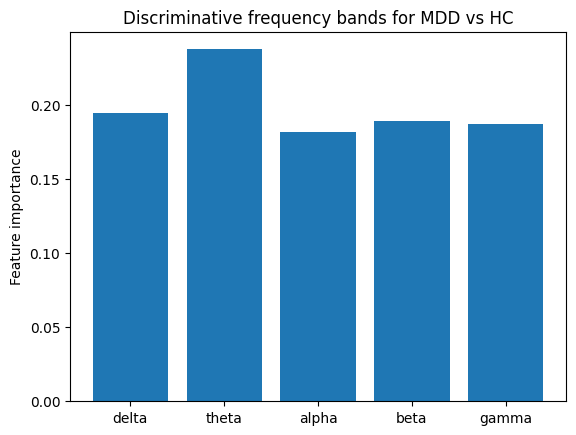

In [ ]:
import matplotlib.pyplot as plt

plt.bar(band_importances.keys(), band_importances.values())
plt.ylabel("Feature importance")
plt.title("Discriminative frequency bands for MDD vs HC")
plt.show()

### Rigorous Statistical Validation

Building on the exploratory findings, I wanted to scientifically validate whether the identified EEG patterns could reliably distinguish MDD patients from healthy controls and determine if any observed differences were statistically meaningful. I used the same Random Forest approach but with proper train-test splitting to evaluate real-world diagnostic performance - testing the model on completely unseen subjects to assess how accurately it could predict depression status.

Using the trained model, I again calculated feature importance scores for each EEG measurement and summed them across electrodes to get frequency band-level importance scores. However, this time I ensured the analysis used only training data to avoid inflated importance estimates.

Lastly, I performed a permutation test where group labels (MDD vs healthy control) were randomly shuffled 1,000 times and the model was re-run each time. This allowed me to determine if the observed importance of each frequency band was significantly greater than what we would expect by random chance, quantified by p-values. This statistical testing proved whether the brain wave differences identified in my exploratory analysis represented genuine biomarkers rather than spurious patterns.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split features/labels
X = df_features.drop(columns=["subject", "group"])
y = df_features["group"].map({"HC": 0, "MDD": 1})

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train, y_train)

# Baseline accuracy
y_pred = clf.predict(X_test)
print("Baseline accuracy:", accuracy_score(y_test, y_pred))

# Get real importances
real_importances = clf.feature_importances_

# Collapse importances by frequency band (ignore electrode index)
band_means_real = {}
for col, imp in zip(X.columns, real_importances):
    band = col.split("_")[-1]   # e.g. "delta", "theta", etc.
    band_means_real[band] = band_means_real.get(band, 0) + imp

# Permutation test
n_perms = 1000
band_means_null = {band: [] for band in band_means_real.keys()}

for i in range(n_perms):
    y_perm = np.random.permutation(y)  # shuffle labels
    clf_perm = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    clf_perm.fit(X_train, np.random.permutation(y_train))  # shuffle training labels

    perm_importances = clf_perm.feature_importances_
    band_sums = {}
    for col, imp in zip(X.columns, perm_importances):
        band = col.split("_")[-1]
        band_sums[band] = band_sums.get(band, 0) + imp

    for band in band_means_null.keys():
        band_means_null[band].append(band_sums.get(band, 0))

    null_importances = {band: [] for band in bands}

# Compute p-values
p_values = {}
for band in band_means_real.keys():
    null_dist = np.array(band_means_null[band])
    real_val = band_means_real[band]
    p_val = (np.sum(null_dist >= real_val) + 1) / (n_perms + 1)  # one-sided
    p_values[band] = p_val

print("Real band importances:", band_means_real)
print("Permutation p-values:", p_values)

Baseline accuracy: 0.36363636363636365


KeyboardInterrupt: 

### Plotting Machine Learning Data

This code creates a bar graph showing whhich EEG frequency bands were most important for distinguishing MDD from HC. Each bar aims to represent the contribution of a frequency band to the model's accuracy, where a taller bar indicates stronger influence. As by the graph, we can see that the theta band shows the highest influence.

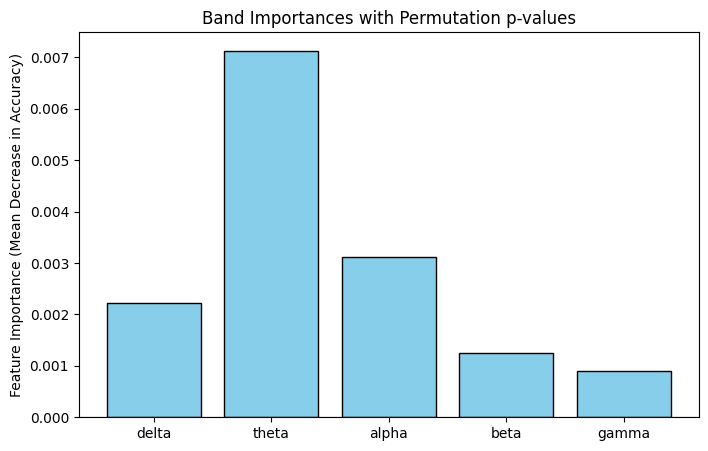

In [ ]:
import matplotlib.pyplot as plt

# Makes sure values are stroed as dictionaries with frequency band as keys
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

if not isinstance(real_importances, dict):
    real_importances = {band: float(val) for band, val in zip(bands, real_importances)}

if not isinstance(p_values, dict):
    p_values = {band: float(val) for band, val in zip(bands, p_values)}


# --- Plot real importances ---
plt.figure(figsize=(8, 5))
bands = list(real_importances.keys())
real_vals = [real_importances[b] for b in bands]
pvals = [p_values[b] for b in bands]

bars = plt.bar(bands, real_vals, color="skyblue", edgecolor="black")
plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Feature Importance (Mean Decrease in Accuracy)")
plt.title("Band Importances with Permutation p-values")

plt.show()

The code below trains the same classifier model into a nul distribution of feature importances. This is essential as by comparing the null to the real importances allows us to determine which frequency bands are statistically informative rather than appearing important by chance.

In [ ]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X, y)
baseline_acc = accuracy_score(y, model.predict(X))
real_importances = dict(zip(bands, model.feature_importances_))

n_permutations = 1000
null_importances = {band: [] for band in bands}

for i in range(n_permutations):
    # Shuffle labels
    y_perm = np.random.permutation(y)
    model.fit(X, y_perm)

    # Store permutation importances
    importances_perm = model.feature_importances_
    for j, band in enumerate(bands):
        null_importances[band].append(importances_perm[j])

# Convert to arrays
for band in bands:
    null_importances[band] = np.array(null_importances[band])

Thus, we plotted a histogram for all EEG frequency bands of feature importances obtained from shuffling labels to represent what would be expected by chance. The real importance is labled as a red dashed line. If the red line falls far outside of the histogram, it indicates that the frequency band contributes to distinguishing MDD from healthy ctonrols more than would be expected randomly.



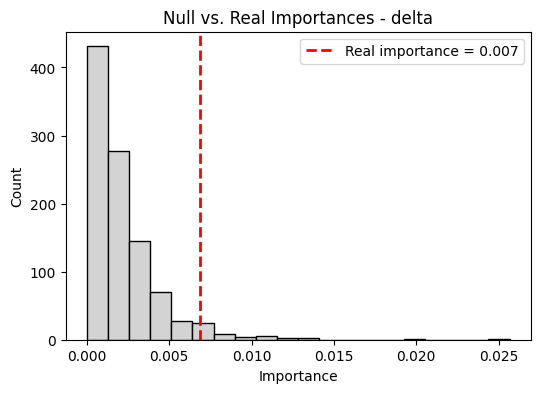

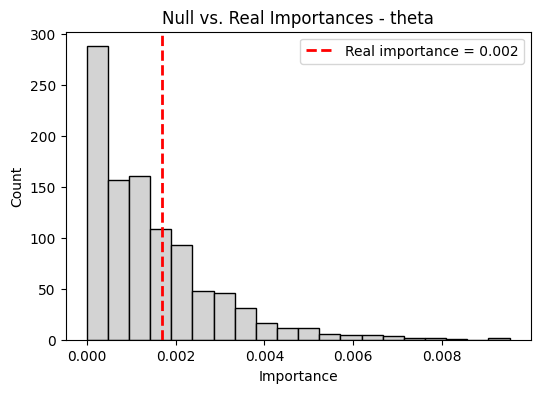

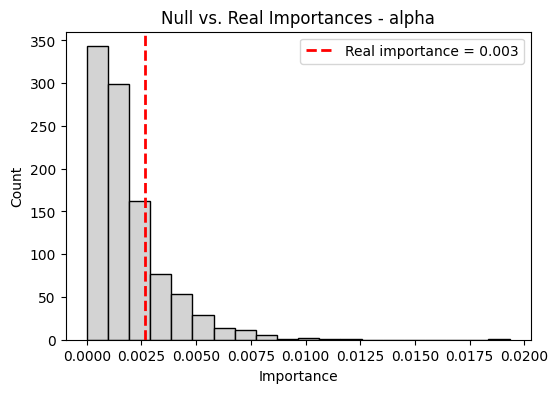

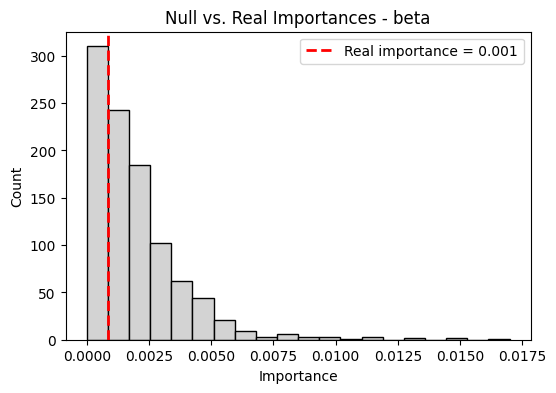

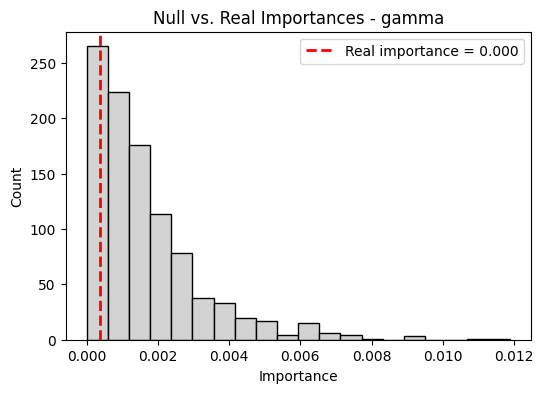

In [ ]:
# Loop through each frequency band
for band in bands:
    plt.figure(figsize=(6,4))

    # Histogram of null importances for this band
    plt.hist(null_importances[band], bins=20, color="lightgray", edgecolor="black")

    # Add vertical line for the real importance
    plt.axvline(real_importances[band], color="red", linestyle="--", linewidth=2,
                label=f"Real importance = {real_importances[band]:.3f}")

    # Title and labels
    plt.title(f"Null vs. Real Importances - {band}")
    plt.xlabel("Importance")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

### Discussion

While the delta band shows higher values in the null distribution, its real importance in model is smaller than theta. This indicates that the theta band linkly is more genuinely discriminative for separating MDD from healthy controls, whereas delta may be from reciving artifically high importance.

### In a biological context

In our analysis, theta-band activity emerged as the most discriminative EEG feature for distinguishing MDD patients from healthy controls. Delta-band features, although frequently highlighted by the model in permutation tests, were less informative in the real data, suggesting that delta may reflect general EEG variability rather than MDD-specific differences.

This finding aligns with prior EEG research that implicates frontal and midline theta rhythms in depression and further connects to clinical outcomes. For instance, de la Salle et al. (2020) reported that early treatment-related changes in prefrontal and midline right frontal theta cordance predicted antidepressant response in MDD patients. Together, these results reinforce the central role of theta-band activity in depression, with our study identifying it as a key diagnostic marker distinguishing patients from controls, and de la Salle et al.’s work highlighting its prognostic value for treatment outcomes.



### Citations

*de la Salle, S., Jaworska, N., Blier, P., Smith, D., & Knott, V. (2020, May 22). Using prefrontal and midline right frontal EEG-derived theta cordance and depressive symptoms to predict the differential response or remission to antidepressant treatment in major depressive disorder. Psychiatry Research: Neuroimaging.* https://www.sciencedirect.com/science/article/pii/S0925492720300810